In [1]:
import numpy as np
from keras.datasets import mnist
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import metrics
import pandas as pd
from joblib import Parallel, delayed

2024-02-24 18:32:07.259053: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 18:32:07.259157: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 18:32:07.259352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 18:32:07.274954: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-24 18:32:08.420492: W tensorflow/compiler/

In [9]:
# MNIST dataset

np.random.seed(100)

# Import MNIST
(a_train, labels_train), (a_test, labels_test) = mnist.load_data()

bigN = a_train.shape[0]
N = a_train.shape[1]

# Smaller sets
def training_set(n, noise):
    sel = np.random.permutation(bigN)
    sel = sel[0 : n]
    a_tr = a_train[sel, :, :] / 255
    b_tr = a_tr + np.sqrt(noise) * np.random.randn(n, N, N)
    return a_tr, b_tr

N_test_set = 100


In [3]:
#Algorithm functions

def prox_g_d(x, Lambda):
    return np.minimum(np.abs(x), Lambda) * np.sign(x)

# Create the operator D (and D^T)
def image_grad(x):
    x_img = x.reshape(N,N)
    x_diff_v = np.diff(x_img,axis=0)
    x_diff_h = np.diff(x_img,axis=1)
    return [np.concatenate((x_diff_v.reshape((N-1)*N),x_diff_h.reshape((N-1)*N)))]

def image_div(x):
    x_v = x[0:(N-1)*N].reshape(N-1,N)
    x_h = x[(N-1)*N:].reshape(N,N-1)
    x_div_v = np.concatenate((np.zeros((1, N)),x_v),axis=0) - np.concatenate((x_v,np.zeros((1,N))),axis=0)
    x_div_h = np.concatenate((np.zeros((N, 1)),x_h),axis=1) - np.concatenate((x_h,np.zeros((N,1))),axis=1)
    return [(x_div_v + x_div_h).reshape(N**2)]

D_Op = scipy.sparse.linalg.LinearOperator((2*N*(N-1),N**2), matvec=image_grad, rmatvec=image_div)

# We compute here D_TV(x, f_\lambda(y)). Inputs vectors, outputs number
def breg_dist_tv(x, y):
    gradx = D_Op.matvec(x)
    grady = D_Op.matvec(y)
    normx = np.linalg.norm(gradx, ord=1)
    return normx - np.dot(np.sign(grady), gradx)

# We want to do here FISTA on the dual of ||x-y||^2+laTV(x) -> min_x

# First the inertial function

iner = 12

def beta(tk, k):
    t_next = (k + iner - 1) / iner
    return (tk - 1) / t_next, t_next

# Now the algorithm

def dual_fista(lam, y):
    y = y.reshape(N ** 2)
    gamma = 1 / 8
    u = np.zeros((2 * N * (N - 1)))
    x = np.zeros(N ** 2)
    tk = 1
    z = u.copy()
    nor1 = 1
    t = 0
    while nor1 >= 1e-8:
        beta_n, tk = beta(tk, t)
        u_prev = u.copy()
        gz = D_Op.matvec(y - D_Op.rmatvec(z))
        u = prox_g_d(z + gamma * gz, lam)
        z = u + beta_n * (u - u_prev)
        x_old = x.copy()
        x = y - D_Op.rmatvec(u)
        nor1 = np.linalg.norm(x - x_old, ord=1)
        t += 1
    return x.reshape((N, N))


In [4]:
# Learning functions

def train_TV(a_tr, b_tr, lamb):  # lamb is a number here
    n_tr = a_tr.shape[0]
    distances = np.zeros(n_tr)
    for i in range(n_tr):
        f_TV = dual_fista(lamb, b_tr[i, :, :]).reshape(N ** 2)
        distances[i] = breg_dist_tv(a_tr[i, :, :].reshape(N ** 2), f_TV)
    return np.mean(distances)

def get_lambda(a_tr, b_tr, lamb): 
    num_cores = -1  #(-1 uses all available cores) 
    TV_err = Parallel(n_jobs=num_cores)(delayed(train_TV)(a_tr, b_tr, la) for la in lamb)
    TV_err = np.array(TV_err)
    min_index = np.argmin(TV_err)
    return lamb[min_index], TV_err.min()


In [ ]:
# L(X_{\widehat{\la}_\Lambda(n)}

lamb = np.logspace(-3, 0, num=50)

N_train_set = 1000
noise_lev = .25

a_train_big, b_train_big = training_set(N_train_set, noise_lev)

N_vec = np.arange(5, 51, 5)
n_it = 30  # The perfect number of iterations is 30

L_at_lhatn = np.zeros((len(N_vec), n_it))
lamb_hatn = np.zeros((len(N_vec), n_it))

for i in range(len(N_vec)):
    print('n=', N_vec[i])
    for j in range(n_it):
        asmall, bsmall = training_set(N_vec[i], noise_lev)
        
        lamb_hatn[i, j] = get_lambda(asmall, bsmall, lamb)[0]
        L_at_lhatn[i, j] = train_TV(a_train_big, b_train_big, lamb_hatn[i, j])


In [ ]:
# Figures

meanDelTV = np.mean(L_at_lhatn, axis=1)
lowerTV = np.quantile(L_at_lhatn, 0.05, axis=1)
upperTV = np.quantile(L_at_lhatn, 0.95, axis=1)

plt.close('all')
fig, ax1 = plt.subplots(figsize=(20, 5), dpi=100)
# fig.suptitle("Excess risk behaviour", fontsize=15)
ax1.plot(N_vec, meanDelTV, '-', label='TV')
ax1.scatter(N_vec, meanDelTV, color='red', s=50)
ax1.fill_between(N_vec, lowerTV, upperTV, alpha=0.2)
ax1.set_ylabel(r'$L(X_{\widehat{\lambda}(n)})$', fontsize=25)
ax1.set_xscale('log')
ax1.set_xlabel(r'$n$', fontsize=25)
#ax1.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("./ERTVden.pdf", bbox_inches='tight')
plt.show(block=False)  # This should go before show

In [6]:
#Behavior wrt the noise level

lamb1 = np.logspace(-2, 1, num=50)
lamb2 = np.logspace(-2, 1, num=10)
tau = np.logspace(-1, 0, num=30)

bign = 500
smalln = 5
n_it = 30

lamb_star = np.zeros(len(tau))
Lstar = np.zeros(len(tau))

lamb_hat = np.zeros((len(tau), n_it))
Lhat = np.zeros((len(tau), n_it))

for i in range(len(tau)):
    print('i=', i)
    a_bign, b_bign = training_set(bign, tau[i])
    lamb_star[i], Lstar[i] = get_lambda(a_bign, b_bign, lamb1)  
    for j in range(n_it):
        a_smalln, b_smalln = training_set(smalln, tau[i])
        lamb_hat[i, j] = get_lambda(a_smalln, b_smalln, lamb2)[0]
        Lhat[i, j] = train_TV(a_bign, b_bign, lamb_hat[i, j])


i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10
i= 11
i= 12
i= 13
i= 14
i= 15
i= 16
i= 17
i= 18
i= 19
i= 20
i= 21
i= 22
i= 23
i= 24
i= 25
i= 26
i= 27
i= 28
i= 29


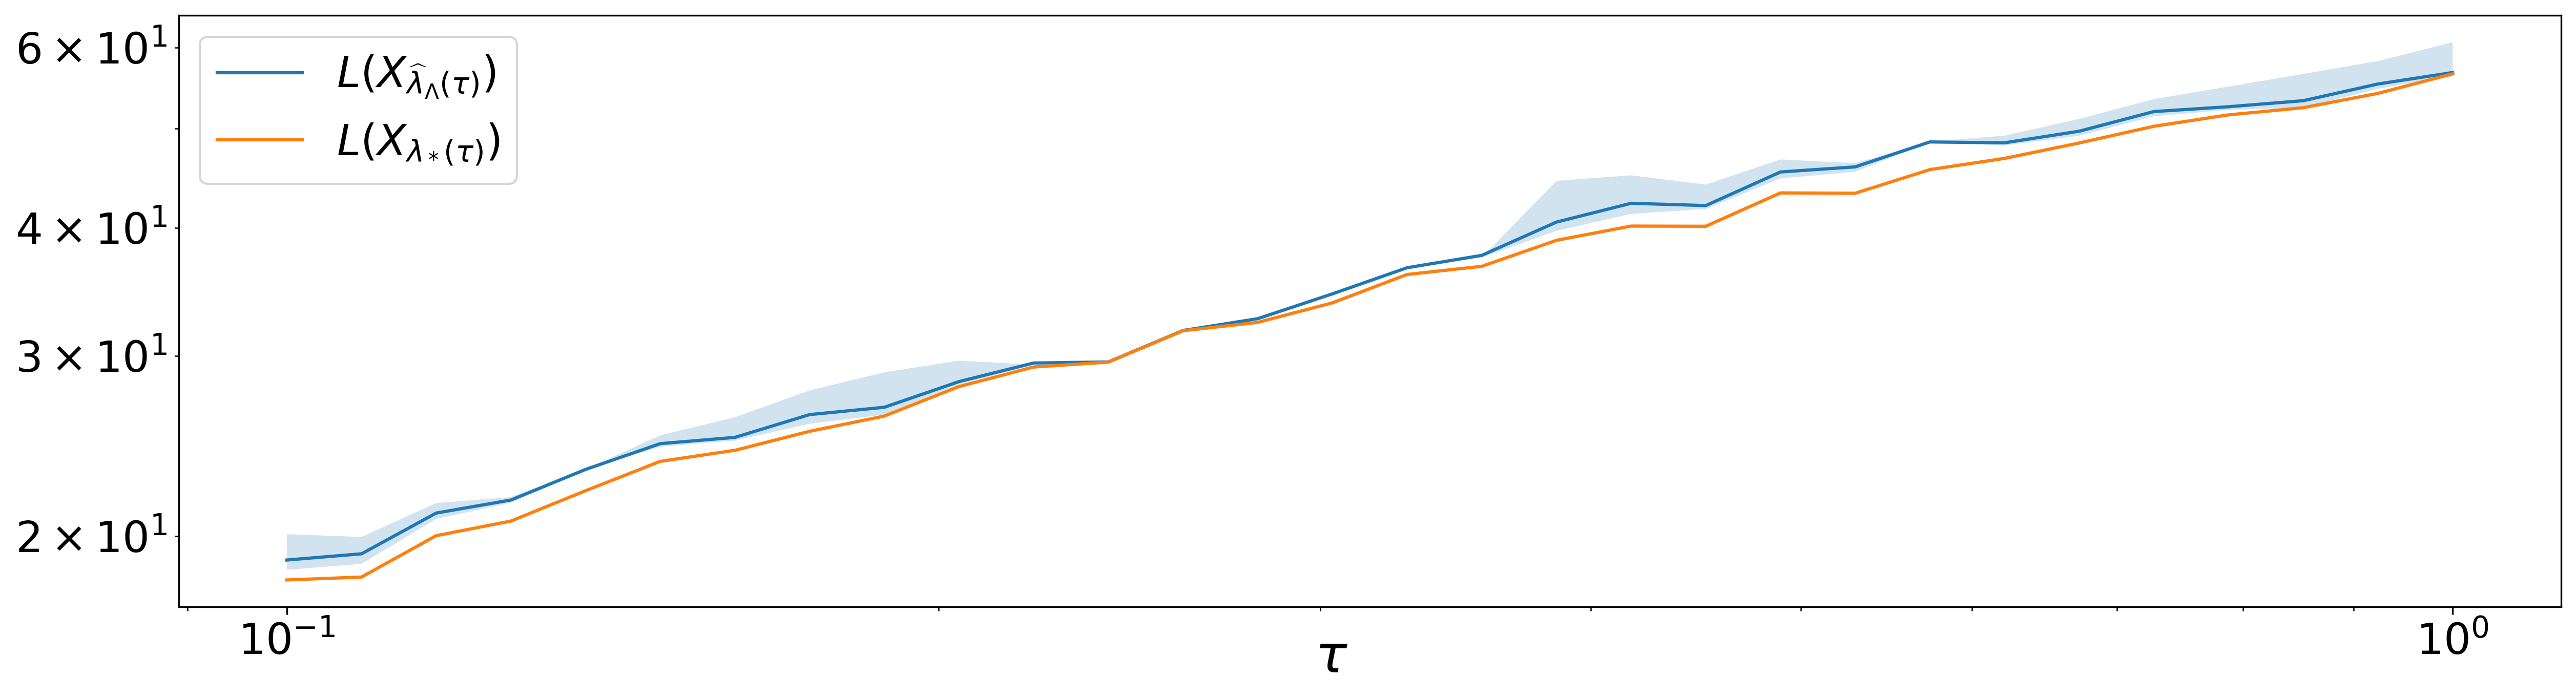

In [7]:
meantv = np.mean(Lhat, axis=1) 
lowertv = np.quantile(Lhat, 0.05, axis=1) 
uppertv = np.quantile(Lhat, 0.95, axis=1) 

plt.close('all')

fig, ax1 = plt.subplots(1, figsize=(20, 5), dpi=300)

ax1.plot(tau, meantv, linestyle='-', label=r'$L(X_{\widehat{\lambda}_\Lambda(\tau)})$')
ax1.fill_between(tau, lowertv, uppertv, alpha=0.2)
ax1.plot(tau, Lstar, linestyle='-', label=r'$L(X_{\lambda_*(\tau)})$')
ax1.legend(fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='minor', labelsize=20)

fig.supxlabel(r"$\tau$", fontsize=25)
#plt.tight_layout()
plt.savefig("./TV2_paper.pdf", bbox_inches='tight')
plt.show(block='False')

In [ ]:
# Behavior on test set

L_lambda_hat1, lambda_hat1 = cvlambda(100, lamb)

print(r'$\widehat{\lambda}$:', lambda_hat1)

L_lambda_hat2, lambda_hat2 = cvlambda(100, lamb)

print(r'$\widehat{\lambda}$:', lambda_hat2)

L_lambda_hat3, lambda_hat3 = cvlambda(100, lamb)

print(r'$\widehat{{\lambda}}$:', lambda_hat3)

L_lambda_hat4, lambda_hat4 = cvlambda(100, lamb)

print(r'$\widehat{{\lambda}}$:', lambda_hat4)

In [ ]:
#Plot for two test example

a1 = a_test[42, :, :]
b1 = b_test[42, :, :]
a1_tv= dual_fista(lambda_hat1, b1)
a2_tv= dual_fista(lambda_hat2, b1)

a2 = a_test[55, :, :]
b2 = b_test[55, :, :]
a3_tv= dual_fista(lambda_hat3, b2)
a4_tv= dual_fista(lambda_hat4, b2)


fig, axs = plt.subplots(2, 4, figsize=(10, 5))

axs[0, 0].imshow(a1, cmap='gray', vmin=0, vmax=1)
axs[0, 0].set_title('Original')
axs[0, 1].imshow(b1, cmap='gray', vmin=0, vmax=1)
axs[0, 1].set_title(r'Noisy, $D_{{\mathrm{{TV}}}}$: {:.4f}'
                    .format(breg_dist_tv(a1.reshape(N**2), b1.reshape(N**2))))
axs[0, 2].imshow(a1_tv, cmap='gray', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\widehat{{\lambda}}_1=0.0494$, $D_{{\mathrm{{TV}}}}$: {:.4f}'
                    .format(breg_dist_tv(a1.reshape(N**2), a1_tv.reshape(N**2))))
axs[0, 3].imshow(a2_tv, cmap='gray', vmin=0, vmax=1)
axs[0, 3].set_title(r'$\widehat{{\lambda}}_2=0.0091$, $D_{{\mathrm{{TV}}}}$: {:.4f}'
                    .format(breg_dist_tv(a1.reshape(N**2), a2_tv.reshape(N**2))))

axs[1, 0].imshow(a2, cmap='gray', vmin=0, vmax=1)
axs[1, 0].set_title('Original')
axs[1, 1].imshow(b2, cmap='gray', vmin=0, vmax=1)
axs[1, 1].set_title(r'Noisy, $D_{{\mathrm{{TV}}}}$: {:.4f}'
                    .format(breg_dist_tv(a2.reshape(N**2), b2.reshape(N**2))))
axs[1, 2].imshow(a3_tv, cmap='gray', vmin=0, vmax=1)
axs[1, 2].set_title(r'$\widehat{{\lambda}}_3=0.0025$, $D_{{\mathrm{{TV}}}}$: {:.4f}'
                    .format(breg_dist_tv(a2.reshape(N**2), a3_tv.reshape(N**2))))
axs[1, 3].imshow(a4_tv, cmap='gray', vmin=0, vmax=1)
axs[1, 3].set_title(r'$\widehat{{\lambda}}_4=0.0002$, $D_{{\mathrm{{TV}}}}$: {:.4f}'
                    .format(breg_dist_tv(a2.reshape(N**2), a4_tv.reshape(N**2))))

plt.tight_layout()
plt.savefig("./tvrecov_test_combined.pdf", dpi=300, bbox_inches='tight')
plt.show()